**Install & import Required Libraries**

In [65]:
!pip install category_encoders

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import category_encoders as ce
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb



**Data Understanding**

In [66]:
df = pd.read_csv("/content/first inten project.csv")

print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

**Feature Engineering & Selection**

In [67]:
df.columns = df.columns.str.strip()
df['date of reservation'] = pd.to_datetime(df['date of reservation'], errors='coerce')
df.dropna(inplace=True)  # Drop rows with invalid dates

df["year"] = df["date of reservation"].dt.year.astype(int)
df["month"] = df["date of reservation"].dt.month.astype(int)

df["is_weekend"] = df["date of reservation"].dt.weekday.isin([5, 6]).astype(int)

df['total_nights'] = df['number of weekend nights'] + df['number of week nights']

df['guest_type'] = df.apply(lambda x: 'Family' if x['number of children'] > 0 else 'Individual/Couple', axis=1)

df.drop(columns=["date of reservation", 'P-C', 'P-not-C', 'Booking_ID', 'number of adults', 'number of children',
                'number of weekend nights', 'number of week nights'], inplace=True)

In [68]:
label_encoder = LabelEncoder()
df["booking_status"] = label_encoder.fit_transform(df["booking status"])
df.drop(columns=["booking status"], inplace=True)

In [69]:
df["guest_type"] = label_encoder.fit_transform(df["guest_type"])

target_encoder = ce.TargetEncoder(cols=["market segment type"])
df["market_segment_encoded"] = target_encoder.fit_transform(df["market segment type"], df["booking_status"])
df.drop(columns=["market segment type"], inplace=True)
df_encoded = pd.get_dummies(df, columns=['room type', 'type of meal'])

In [70]:
columns_to_scale = ['lead time', 'average price', 'total_nights']
scaler = RobustScaler()
df_scaled = df_encoded.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])

<ipython-input-71-a3005e7ce6f6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=status_percentage.index, y=status_percentage, palette=['#ff9999', '#66b3ff'])


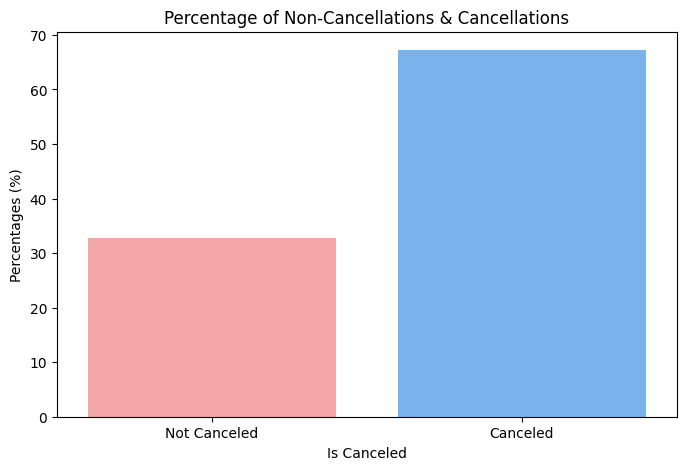

In [71]:
status_percentage = df_encoded['booking_status'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=status_percentage.index, y=status_percentage, palette=['#ff9999', '#66b3ff'])
plt.title('Percentage of Non-Cancellations & Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentages (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0, 80, 10))

plt.show()

**Train-test split**

In [72]:
X = df_scaled.drop(columns='booking_status', axis=1)
y = df_scaled['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Logistic Regrresion**

In [73]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.57      0.64      2377
           1       0.81      0.89      0.85      4873

    accuracy                           0.79      7250
   macro avg       0.77      0.73      0.74      7250
weighted avg       0.78      0.79      0.78      7250



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**K-Nearest Neighbors (KNN)**

In [74]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      2377
           1       0.88      0.90      0.89      4873

    accuracy                           0.85      7250
   macro avg       0.83      0.82      0.82      7250
weighted avg       0.85      0.85      0.85      7250



**XGBoost Classifier**

In [75]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      2377
           1       0.89      0.92      0.91      4873

    accuracy                           0.87      7250
   macro avg       0.86      0.85      0.85      7250
weighted avg       0.87      0.87      0.87      7250



**Balance the Data Using SMOTE**

In [76]:
from imblearn.over_sampling import SMOTE

X = df_encoded.drop(columns='booking_status', axis=1)
y = df_encoded['booking_status']

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("Balanced Class Distribution:")
print(y_balanced.value_counts())

Balanced Class Distribution:
booking_status
1    24366
0    24366
Name: count, dtype: int64


<ipython-input-77-e7c26d71addb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=status_percentage_balanced.index, y=status_percentage_balanced, palette=['green', 'red'])  # Green for Not Canceled, Red for Canceled


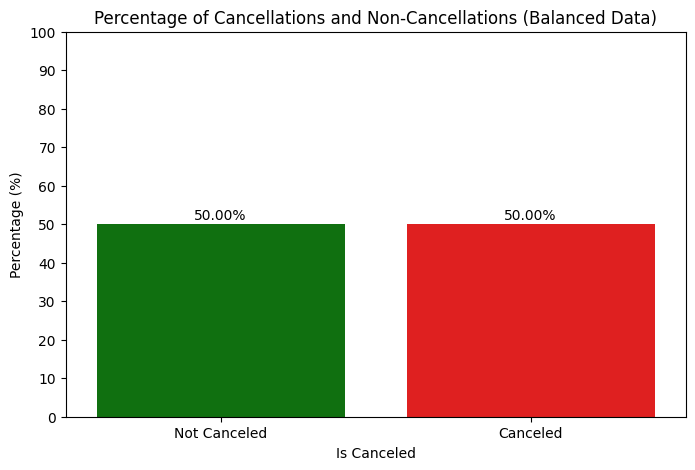

In [77]:
status_percentage_balanced = y_balanced.value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=status_percentage_balanced.index, y=status_percentage_balanced, palette=['green', 'red'])
plt.title('Percentage of Cancellations and Non-Cancellations (Balanced Data)')
plt.xlabel('Is Canceled')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0, 101, 10))

for i, p in enumerate(status_percentage_balanced):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

**Split the Balanced Data into Training and Testing  sets**

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

print("Training Set Distribution:")
print(y_train.value_counts())

print("Testing Set Distribution:")
print(y_test.value_counts())

Training Set Distribution:
booking_status
1    19493
0    19492
Name: count, dtype: int64
Testing Set Distribution:
booking_status
0    4874
1    4873
Name: count, dtype: int64


**Retrain and Evaluate Models on Balanced Data**

In [79]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)

print("Logistic Regression Classification Report (Balanced Data):")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      4874
           1       0.79      0.81      0.80      4873

    accuracy                           0.80      9747
   macro avg       0.80      0.80      0.80      9747
weighted avg       0.80      0.80      0.80      9747



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [80]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print("KNN Classification Report (Balanced Data):")
print(classification_report(y_test, y_pred_knn))

KNN Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      4874
           1       0.87      0.81      0.84      4873

    accuracy                           0.85      9747
   macro avg       0.85      0.85      0.85      9747
weighted avg       0.85      0.85      0.85      9747



In [81]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)

print("XGBoost Classification Report (Balanced Data):")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report (Balanced Data):
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4874
           1       0.88      0.91      0.90      4873

    accuracy                           0.89      9747
   macro avg       0.89      0.89      0.89      9747
weighted avg       0.89      0.89      0.89      9747

